## Практическое задание N 3

Исчерпывающую информацию с теорией, кодом и примерами можно найти в [статье](https://www.ethanrosenthal.com/2016/10/19/implicit-mf-part-1/)

### Ответы на вопросы семинара.

**Ожидание:**
- Отправляем e-mail с топ-10 товарами, отсортированными по вероятности

**Реальность:**
- Чего хочет менеджер от рекомендательной системы? (рост показателя X на Y% за Z недель)
- По-хорошему надо бы предварительно посчитать потенциальный эффект от рекоммендательной системы (Оценки эффектов у менеджера и у вас могут сильно не совпадать: как правило, вы знаете про данные больше)
- А у нас вообще есть e-mail-ы пользователей? Для скольки %? Не устарели ли они?
- Будем ли использовать СМС и push-уведомления в приложении? Может, будем печатать рекомендации на чеке после оплаты на кассе?
- Как будет выглядеть e-mail? (решаем задачу топ-10 рекомендаций или ранжирования? И топ-10 ли?)
- Какие товары должны быть в e-mail? Есть ли какие-то ограничения (только акции и т п)?
- Сколько денег мы готовы потратить на привлечение 1 юзера? CAC - Customer Aquisition Cost. Обычно CAC = расходы на коммуникацию + расходы на скидки
- Cколько мы хотим зарабатывать с одного привлеченного юзера?
---
- А точно нужно сортировать по вероятности?
- Какую метрику использовать?
- Сколько раз в неделю отпрпавляем рассылку?
- В какое время отправляем рассылку?
- Будем отправлять одному юзеру много раз наши рекоммендации. Как добиться того, чтобы они хоть немного отличались?
- Нужно ли, чтобы в одной рассылке были *разные* товары? Как определить, что товары *разные*? Как добиться того, чтобы они были разными?
- И многое другое:)

**В итоге договорились, что:**
- Хотим повысить выручку минимум на 6% за 4 месяца. Будем повышать за счет роста Retention минимум на  3% и среднего чека минимум на 3%
- Топ-5 товаров, а не топ-10 (В e-mail 10 выглядят не красиво, в push и на чек больше 5 не влезает)
- Рассылаем в e-mail (5% клиентов) и push-уведомлении (20% клиентов), печатаем на чеке (все оффлайн клиенты)
- **3 товара с акцией** (Как это учесть? А если на товар была акция 10%, а потом 50%, что будет стоять в user-item матрице?)
- **1 новый товар** (юзер никогда не покупал. Просто фильтруем аутпут ALS? А если у таких товаров очень маленькая вероятность покупки? Может, использовать другую логику/модель?)
- **1 товар для роста среднего чека** (товары минимум дороже чем обычно покупает юзер. Как это измерить? На сколько дороже?)

> **учет товаров с акцией** - Как вариант создать словарь товаров по акции, при обязательной рекомендации выбрать по скору из модели с помощью функции **model.rank_items** указав в selected_item товары по акцией

> **1 новый товар** - Cтратегия следующая: находим похожие профили с помощью **model_simular_user**. далее вычитаем товары которые уже есть.

> **1 товар для роста среднего чека** - Здесь следует использовать например **75% квантиль** по нормальному распределению стоимости товара.

### Подключение библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight, tfidf_weight  # взвешивание

# Функции из 1-ого вебинара
import os, sys

module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

from metrics import precision_at_k, recall_at_k
import itertools
import copy

### Чтение данных о взаимодействиях. Разделение на обучающую выборку и тестовую

In [2]:
data = pd.read_csv('../data/retail_train.csv')

data.columns = [col.lower() for col in data.columns]
data.rename(columns={'household_key': 'user_id',
                     'product_id': 'item_id'},
            inplace=True)

test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

data_train.head(10)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0
5,2375,26984851516,1,826249,2,1.98,364,-0.60,1642,1,0.0,0.0
6,2375,26984851516,1,1043142,1,1.57,364,-0.68,1642,1,0.0,0.0
7,2375,26984851516,1,1085983,1,2.99,364,-0.40,1642,1,0.0,0.0
8,2375,26984851516,1,1102651,1,1.89,364,0.00,1642,1,0.0,0.0
9,2375,26984851516,1,6423775,1,2.00,364,-0.79,1642,1,0.0,0.0


### Группировка user-item для обуч и тестовой выборок

In [3]:
#train
result_train = data_train.groupby('user_id')['item_id'].unique().reset_index()
result_train.columns = ['user_id', 'actual']
result_train.head(2)

,user_id,actual
0,1,"[825123, 831447, 840361, 845307, 852014, 85498..."
1,2,"[854852, 930118, 1077555, 1098066, 5567388, 55..."


In [4]:
#test
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns = ['user_id', 'actual']
result.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


###   Создание матрицы взаимодействия (Выделение 5000 популярных, создание фиктивного товара)

In [5]:
#train
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

In [6]:
#train
# Заведем фиктивный item_id

data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix = pd.pivot_table(data_train,
                                  index='user_id', columns='item_id',
                                  values='quantity',  # Можно пробовать другие варианты
                                  aggfunc='count',
                                  fill_value=0
                                  )

user_item_matrix = user_item_matrix.astype(float)  # необходимый тип матрицы для implicit

# переведем в формат sparse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(3)

item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Создание словаря №-id

In [7]:
#train
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

### Построение бейзлайна на ALS

In [8]:
%%time
#train
model = AlternatingLeastSquares(factors=100,  #количество k
                                regularization=0.001,  # вариация
                                iterations=15,  # вариация
                                calculate_training_loss=True,
                                num_threads=4)  # 4 потока

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=False)

recs = model.recommend(userid=userid_to_id[6],  # userid - id от 0 до N
                       user_items=csr_matrix(user_item_matrix).tocsr(),  # на вход user-item matrix
                       N=5,  # кол-во рекомендаций
                       filter_already_liked_items=False,
                       filter_items=None,
                       recalculate_user=True)

CPU times: total: 58.6 s
Wall time: 16.6 s


In [9]:
[id_to_itemid[rec[0]] for rec in recs]

[1007195, 1023720, 866211, 986912, 1051516]

### Генерация рекомендаций для всех пользователей

In [10]:
def get_recommendations(user, model, N=5):
    res = [id_to_itemid[rec[0]] for rec in
           model.recommend(userid=userid_to_id[user],
                           user_items=sparse_user_item,  # на вход user-item matrix
                           N=N,
                           filter_already_liked_items=False,
                           filter_items=None,
                           recalculate_user=True)]
    return res

In [11]:
%%time
#test    
result['als'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
result.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1).mean()

CPU times: total: 4min 58s
Wall time: 1min 58s


0.1613124387855044

In [12]:
result.head(2)

,user_id,actual,als
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[979707, 1100972, 1033142, 5569374, 1105488]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[5568378, 1106523, 938700, 910032, 1133018]"


In [13]:
%%time
#train   
result_train['als'] = result_train['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
result_train.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1).mean()

CPU times: total: 6min 7s
Wall time: 2min 24s


0.7365346138455382

In [16]:
result_train.head(2)

,user_id,actual,als
0,1,"[825123, 831447, 840361, 845307, 852014, 85498...","[979707, 1100972, 1033142, 5569374, 1105488]"
1,2,"[854852, 930118, 1077555, 1098066, 5567388, 55...","[1133018, 999999, 1106523, 5569230, 1082185]"


### Построение модели обучения

In [17]:
#train = csr_matrix(user_item_matrix).T.tocsr()
#train_actual = result_train
#test_actual = result
#epochs=range(2, 40, 2)
def learning_curve(model, train, train_actual, test_actual, epochs, k=5):
    prev_epoch = 0
    train_precision = []
    test_precision = []

    for epoch in epochs:
        model.iterations = epoch - prev_epoch
        if not hasattr(model, 'user_vectors'):
            model.fit(train, show_progress=False)
        else:
            model.fit_partial(train, show_progress=False)

        test_actual['als'] = test_actual['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
        train_actual['als'] = train_actual['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))

        train_precision.append(train_actual.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1).mean())
        test_precision.append(test_actual.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1).mean())
        row = [epoch, train_precision[-1], test_precision[-1]]
        print(f'epoch: {epoch}, p@k train: {train_precision[-1]}, p@k test: {test_precision[-1]}')
        prev_epoch = epoch
    return model, train_precision, test_precision


In [18]:
model = AlternatingLeastSquares(factors=100,
                                #количество k или размерность который мы подбираем для матриц при разложении ,
                                # лучший параметр при разложении по версии статьи из вебинара 300-400
                                regularization=0.001,  # можно подобрать лучший
                                iterations=15,  # можно подобрать лучший
                                calculate_training_loss=True,
                                num_threads=4)  # 4 потока
model1, train_precision1, test_precision1 = learning_curve(model, csr_matrix(user_item_matrix).T.tocsr(),
                                                           result_train, result, epochs=range(2, 40, 2), k=5)

epoch: 2, p@k train: 0.6569027611044418, p@k test: 0.18374142997061707
epoch: 4, p@k train: 0.6886754701880752, p@k test: 0.16807051909892265
epoch: 6, p@k train: 0.706842737094838, p@k test: 0.16376101860920664
epoch: 8, p@k train: 0.7180472188875551, p@k test: 0.16190009794319296
epoch: 10, p@k train: 0.7290116046418568, p@k test: 0.1622918707149853
epoch: 12, p@k train: 0.7322128851540616, p@k test: 0.16258570029382957
epoch: 14, p@k train: 0.735734293717487, p@k test: 0.16278158667972575
epoch: 16, p@k train: 0.7386154461784714, p@k test: 0.1604309500489716
epoch: 18, p@k train: 0.742296918767507, p@k test: 0.16121449559255635
epoch: 20, p@k train: 0.7453381352541016, p@k test: 0.15964740450538686
epoch: 22, p@k train: 0.7474989995998399, p@k test: 0.16052889324191968
epoch: 24, p@k train: 0.7482993197278911, p@k test: 0.16043095004897162
epoch: 26, p@k train: 0.748219287715086, p@k test: 0.15994123408423117
epoch: 28, p@k train: 0.7485394157663064, p@k test: 0.16043095004897162
ep

In [19]:
def grid_search_learning_curve(base_model, train, train_actual, test_actual, param_grid,
                               user_index=None, patk=5, epochs=range(2, 10, 2)):
    """
    "Inspired" (stolen) from sklearn gridsearch
    https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/model_selection/_search.py
    """
    curves = []
    keys, values = zip(*param_grid.items())
    for v in itertools.product(*values):
        params = dict(zip(keys, v))
        this_model = copy.deepcopy(base_model)
        print_line = []
        for k, v in params.items():
            setattr(this_model, k, v)
            print_line.append((k, v))

        print(' | '.join('{}: {}'.format(k, v) for (k, v) in print_line))
        _, train_patk, test_patk = learning_curve(this_model, train, train_actual, test_actual, epochs, k=patk)
        curves.append({'params': params,
                       'patk': {'train': train_patk, 'test': test_patk}})
    return curves

### Поиск гипер параметров по сетке

In [20]:
param_grid = {'num_factors': [80, 120],
              'regularization': [ 1e-1, 1e1, 1e2],
              'alpha': [ 100, 500, 1000]}
base_model = AlternatingLeastSquares()

In [21]:
curves = grid_search_learning_curve(base_model, csr_matrix(user_item_matrix).T.tocsr(),
                                    result_train, result,
                                    param_grid,
                                    user_index=None,
                                    patk=5)

num_factors: 80 | regularization: 0.1 | alpha: 100
epoch: 2, p@k train: 0.6769107643057223, p@k test: 0.19255631733594517
epoch: 4, p@k train: 0.6872348939575831, p@k test: 0.1762977473065622
epoch: 6, p@k train: 0.697719087635054, p@k test: 0.16993143976493633
epoch: 8, p@k train: 0.7052420968387354, p@k test: 0.169539666993144
num_factors: 80 | regularization: 0.1 | alpha: 500
epoch: 2, p@k train: 0.6650660264105642, p@k test: 0.19745347698334967
epoch: 4, p@k train: 0.6849139655862344, p@k test: 0.17962781586679727
epoch: 6, p@k train: 0.6979591836734693, p@k test: 0.17277179236043094
epoch: 8, p@k train: 0.7078831532613046, p@k test: 0.16865817825661114
num_factors: 80 | regularization: 0.1 | alpha: 1000
epoch: 2, p@k train: 0.6694677871148459, p@k test: 0.19804113614103824
epoch: 4, p@k train: 0.6889955982392957, p@k test: 0.1805093046033301
epoch: 6, p@k train: 0.6994797919167667, p@k test: 0.17286973555337903
epoch: 8, p@k train: 0.7110044017607042, p@k test: 0.167384916748286
n

In [22]:
best_curves = sorted(curves, key=lambda x: max(x['patk']['test']), reverse=True)

#### Лучшее решение

In [23]:
print(best_curves[0]['params'])
max_score = max(best_curves[0]['patk']['test'])
print(max_score)
iterations = range(2, 40, 2)[best_curves[0]['patk']['test'].index(max_score)]
print('Epoch: {}'.format(iterations))

{'num_factors': 120, 'regularization': 10.0, 'alpha': 1000}
0.24045053868756122
Epoch: 2


In [24]:
best_curves

[{'params': {'num_factors': 120, 'regularization': 10.0, 'alpha': 1000},
  'patk': {'train': [0.7115646258503402,
    0.723889555822329,
    0.7274909963985594,
    0.7310124049619847],
   'test': [0.24045053868756122,
    0.2013712047012733,
    0.19059745347698337,
    0.18756121449559254]}},
 {'params': {'num_factors': 80, 'regularization': 10.0, 'alpha': 500},
  'patk': {'train': [0.7140456182472988,
    0.7294917967186875,
    0.7330132052821128,
    0.7330132052821128],
   'test': [0.23849167482859945,
    0.19999999999999998,
    0.18961802154750246,
    0.1841332027424094]}},
 {'params': {'num_factors': 80, 'regularization': 10.0, 'alpha': 100},
  'patk': {'train': [0.7154861944777912,
    0.7282112845138055,
    0.7333333333333333,
    0.7339735894357743],
   'test': [0.2359451518119491,
    0.2060724779627816,
    0.19490695396669933,
    0.19089128305582764]}},
 {'params': {'num_factors': 120, 'regularization': 10.0, 'alpha': 100},
  'patk': {'train': [0.7264505802320927,
  

### Построение графиков, выводы

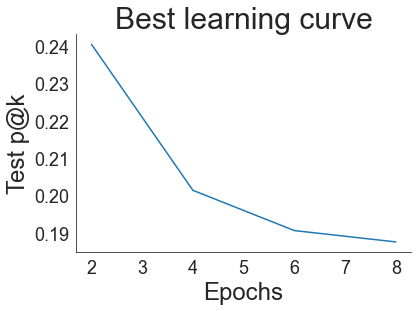

In [25]:
import seaborn as sns

sns.set_style('white')
fig, ax = plt.subplots()
sns.despine(fig);
plt.plot([2, 4, 6, 8], best_curves[0]['patk']['test']);
plt.xlabel('Epochs', fontsize=24);
plt.ylabel('Test p@k', fontsize=24);
plt.xticks(fontsize=18);
plt.yticks(fontsize=18);
plt.title('Best learning curve', fontsize=30);

По результатам выявлены лучшие параметры и построен график зависимости p@k от количества эпох
{'num_factors': 120, 'regularization': 10.0, 'alpha': 1000}
0.24045053868756122
Epoch: 2